# IMBd Project 

## Libraries

In [41]:
# Import Libraries
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import fa2
import math
import community
import matplotlib.cm as cm
from __future__ import division
import matplotlib.image as mpimg
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import io
from collections import Counter
from wordcloud import WordCloud
from scipy.special import zeta
# Rendering Parameters
title_font = {'family': 'sans-serif',
        'color':  '#000000',
        'weight': 'normal',
        'size': 16,
        }

## Clean Data

We have two type of data:
* A file containing reviews
* IMBd data bases containing actors, movies and grades <br>

As Data Bases contain too many lines compared to the review files, we first have to clean our data bases files to keep only the information about the movies in the reviews file.

#### Get the review movies

In [3]:
###################################
# Initialise a movie dictionnary
###################################

# Function. to convert movie or actor id to sting key
def idToString(iD, base): # base = "tt" for movies or "nm" for actors
    if iD<10:
        return base+"000000"+str(iD)
    if iD<100:
        return base+"00000"+str(iD)
    if iD<1000:
        return base+"0000"+str(iD)
    if iD<10000:
        return base+"000"+str(iD)
    if iD<100000:
        return base+"00"+str(iD)
    if iD<1000000:
        return base+"0"+str(iD)
    else:
        return base+str(iD)
    
# Create movie dictionnary
movieDict = {}
lastMovie = 9999999 #last movie ID
for i in range(lastMovie):
    movieDict[idToString(i+1,"tt")] = False
    



In [4]:
###################################
# Get the movies to keep
###################################

# List of the reviews documents
listReviewsDocuments = ["train/urls_neg.txt","test/urls_neg.txt","train/urls_pos.txt","test/urls_pos.txt","train/urls_unsup.txt"]

# Fill in the dictionnary
for document in listReviewsDocuments:
    files = io.open("aclImdb/"+document, mode="r", encoding="utf-8")
    for row in files:
        w = re.findall(r'http://www.imdb.com/title/(\w*)/usercomments',row)
        movieDict[w[0]] = True

In [5]:
###################################
# Create an Actor Dict
###################################
actorDict = {}
lastActor = 29999999 #last movie ID
for i in range(lastActor):
    actorDict[idToString(i+1,"nm")] = False
    


#### Clean the data base documents

In [7]:
###################################
# key to movie name file
###################################
path = "DATA/title.basics.txt"
cleanPath = "DATA/title.basics.clean.txt"
files = io.open(path, mode="r", encoding="utf-8")
cleanfile = io.open(cleanPath, mode="w", encoding="utf-8")
b=False # skip the first line
count =0
for row in files:
    if b:
        split=row.split("\t")
        key = split[0]
        if movieDict[key]:
            if (split[1] in ['movie', 'tvMovie']):
                cleanfile.write(row)
                count +=1
            else:
                movieDict[key]=False
    else:
        b=True
files.close()
cleanfile.close()

print "There are "+str(count)+" movies considered"

There are 10735 movies considered


In [8]:
##########################################################
# film actors links file : Clean + get actor dictionnary
##########################################################
path = "DATA/title.principals.txt"
cleanPath = "DATA/title.principals.clean.txt"
files = io.open(path, mode="r", encoding="utf-8")
cleanfile = io.open(cleanPath, mode="w", encoding="utf-8")
roleCheckList = ["actor", "actress", "self"] #check if it is an actor
nLinks = 0
i=False # skip first line
for row in files:
    if i:
        split = row.split("\t") 
        key = split[0]
        if movieDict[key]:
            if (split[3] in roleCheckList or split[4] in roleCheckList or split[5] in roleCheckList):
                cleanfile.write(row)
                actorDict[split[2]]=True
                nLinks  +=1
            
    else:
        i=True

files.close()
cleanfile.close()

#REMOVE ERRORS
actorDict["nm0547707"]=False
actorDict['nm0547707']=False
actorDict['nm0809728']=False
actorDict['nm2442859']=False
actorDict['nm1996613']=False
actorDict['nm0600636']=False
actorDict['nm1824417']=False
actorDict['nm2440192']=False
actorDict['nm1754167']=False

print "There are "+str(nLinks-9)+" actors considered"

There are 43553 actors considered


In [9]:
###################################
# key to actor name file
###################################
path = "DATA/name.basics.txt"
cleanPath = "DATA/name.basics.clean.txt"
files = io.open(path, mode="r", encoding="utf-8")
cleanfile = io.open(cleanPath, mode="w", encoding="utf-8")
count = 0
i=False
for row in files:
    if i:
        split = row.split("\t")
        key = split[0]
        if actorDict[key]:
            cleanfile.write(row)
    else:
        i=True

files.close()
cleanfile.close()

## Load Data

In [10]:
###################################
# Create a ratings dict
###################################
ratingDict = {}
path = "DATA/ratings.txt"
files = io.open(path, mode="r", encoding="utf-8")
count = 0
i=False # skip first line
for row in files:
    if i:
        key = row[:9]
        if movieDict[key]:
            split = row.split("\t") 
            ratingDict[key] = float(split[1])
    else:
        i=True

files.close()
cleanfile.close()

In [11]:
###################################
# Create a movie name dict
###################################
movieNameDict = {}
moviesList = []
path = "DATA/title.akas.clean.txt"
files = io.open(path, mode="r", encoding="utf-8")
count = 0
for row in files:
    split = row.split("\t") 
    if movieDict[split[0]] and not (split[0] in movieNameDict) and (split[0] in ratingDict) and "original" in row :
        movieNameDict[split[0]] = split[2]
        moviesList.append(split[0])

files.close()
cleanfile.close()

In [12]:
###################################
# Create an actor name dict
###################################
actorNameDict = {}
actorGenderDict = {}
actorsList = []
path = "DATA/name.basics.clean.txt"
files = io.open(path, mode="r", encoding="utf-8")
count = 0
for row in files:
    split = row.split("\t") 
    if actorDict[split[0]] and not (split[0] in actorNameDict):
        actorNameDict[split[0]] = split[1]
        if "actor" in split[4]:
            actorGenderDict[split[0]] = "M"
        else:
            actorGenderDict[split[0]] = "F"
        actorsList.append(split[0])
files.close()
cleanfile.close()

In [13]:
###################################
# Build a movie data frame
###################################
moviesData = {"iD" : movieNameDict.keys(), "Title": pd.Series(np.zeros(len(moviesList))), "Rating":pd.Series(np.zeros(len(moviesList)))}
moviesDF = pd.DataFrame(moviesData)
for i in moviesDF.index:
    iD =moviesDF.loc[i].at["iD"]
    moviesDF.loc[i, "Title"]= movieNameDict[iD]
    moviesDF.loc[i, "Rating"] = ratingDict[iD]
moviesDF.sort_values("Rating", ascending=False).head(10)


,Rating,Title,iD
8686,9.1,The Regard of Flight,tt0134050
7737,9.0,Notre-Dame de Paris,tt0285800
8377,8.9,Ko to tamo peva,tt0076276
4887,8.9,12 Angry Men,tt0050083
9860,8.9,Schindler's List,tt0108052
1157,8.9,The Lord of the Rings: The Return of the King,tt0167260
8305,8.8,Saban Oglu Saban,tt0253614
1389,8.8,Sobache serdtse,tt0096126
2151,8.8,The Art of Amália,tt0204839
9079,8.8,The Lord of the Rings: The Fellowship of the Ring,tt0120737


In [14]:
###################################
# Build an actor data frame
###################################
actorsData = {"iD": actorNameDict.keys(), "Name": pd.Series(np.zeros(len(actorsList))),"Gender": pd.Series(np.zeros(len(actorsList)))}
actorsDF = pd.DataFrame(actorsData)
for i in actorsDF.index:
    iD = actorsDF.loc[i].at["iD"]
    actorsDF.loc[i, "Name"]= actorNameDict[iD]
    actorsDF.loc[i, "Gender"] = actorGenderDict[iD]
actorsDF.head(10)

,Gender,Name,iD
0,F,Bobbie Bresee,nm0107679
1,F,Malgorzata Rozniatowska,nm0747647
2,M,Ahmet Ugurlu,nm0880128
3,F,Laura Nativo,nm1137466
4,F,Jordy Benattar,nm0070237
5,M,Özkan Ugur,nm0880126
6,M,John Foss,nm1458561
7,M,Panayiotis Hartomatzidis,nm0367186
8,M,Simon Abkarian,nm0008787
9,F,Victoria Snow,nm0795281


In [15]:
###################################
# Create a links list
###################################
path = "DATA/title.principals.clean.txt"
files = io.open(path, mode="r", encoding="utf-8")
links = np.empty((nLinks,2),dtype=object)
count = 0
for row in files:
    split = row.split("\t")
    if actorDict[split[2]]:
        links[count,0]= split[0]
        links[count,1]= split[2]
        count+=1

files.close()
cleanfile.close()

In [16]:
###################################
# Create an actor links list
###################################
actorsLinks = []
for i in range(count-1):
    j = i+1
    while (j<count) and (links[i,0]==links[j,0]):
        actorsLinks.append([links[i,1],links[j,1],links[i,0]]) #[actor1, actor2, movie]
        j+=1

## Create the graph

In [17]:
###################################
# Create the actors Graph
###################################
G = nx.Graph()
#add nodes
for i in actorsDF.index:
    G.add_node(actorsDF.loc[i].at["iD"], Name= actorsDF.loc[i, "Name"], Gender = actorsDF.loc[i, "Gender"])

#add links
for link in actorsLinks:
    if link[0]  != link[1]: 
        if G.has_edge(link[0],link[1]):                         
            G[link[0]][link[1]]["weight"] +=1 
            G[link[0]][link[1]]["movies"].append(link[2])
            G[link[0]][link[1]]["avRating"] = (G[link[0]][link[1]]["avRating"])*(1-1.0/G[link[0]][link[1]]["weight"])+ratingDict[link[2]]/G[link[0]][link[1]]["weight"]
        else:
            G.add_edge(link[0], link[1], weight = 1, movies = [link[2]], avRating = ratingDict[link[2]]) 


In [18]:
###################################
# Remove degree 0 nodes
###################################
nodes = [n for n in G.nodes()]
for n in nodes:
    if G.degree[n]<1:
        G.remove_node(n)

In [19]:
G.number_of_nodes()

23959

In [20]:
G =  max(nx.connected_component_subgraphs(G), key=len)

## Visualize the network

In [21]:
#----------------------
# PREPARE THE DRAWING
#----------------------

mBlue = "#55638A"     # For actor
fRed = "#9E1030"    # For actress
colors = {}  # Build the color and size arrays
exclusion = []
k=0
for n in G.nodes:
    try:
        if G.nodes[n]['Gender'] == "F":    # Set the colors according to the party
            colors[n]= fRed
        else:
            colors[n]= mBlue
    except:
        exclusion.append(n)
    

# Get the weight of the edges to adapt the width of the edges 
edges,weights = zip(*nx.get_edge_attributes(G,"weight").items())


In [22]:
# Get the actor/actress with the biggest number of collaborations
sizes = {}
actorsDF["Collab"] = pd.Series(np.zeros(len(actorsList)))
for i in actorsDF.index:
    iD =actorsDF.loc[i].at["iD"]
    if iD in G.nodes():
        edges = list(G.edges(iD))
        ogStrength = 0
        for e in edges:
            ogStrength += G.get_edge_data(*e)["weight"] 
        actorsDF.loc[i, "Collab"]= ogStrength 
        sizes[iD] = ogStrength
    else :
        actorsDF.loc[i, "Collab"]= 0
actorsDF=actorsDF.sort_values("Collab", ascending=False)

# Build a label dictionnary with the name of the congress members to highlight
SortedNames = np.asarray(actorsDF["Name"])
SortedNames = SortedNames[:10]
labels = {}
for n in G.nodes():
    name = actorNameDict[n]
    if name in SortedNames:
        labels[n]="\n\n"+name
    else:
        labels[n]=""

In [23]:
#--------------------------------------------
# USE THE FA ALGORITHM TO SET THE POSITIONS
#--------------------------------------------

# Get the Force Atlas positions
forceatlas2 = fa2.ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=0.005,
                          strongGravityMode=False,
                          gravity=20,

                          # Log
                          verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=3000)

100%|██████████| 3000/3000 [13:10<00:00,  4.08it/s]

('BarnesHut Approximation', ' took ', '376.17', ' seconds')
('Repulsion forces', ' took ', '372.51', ' seconds')
('Gravitational forces', ' took ', '1.64', ' seconds')
('Attraction forces', ' took ', '2.97', ' seconds')
('AdjustSpeedAndApplyForces step', ' took ', '9.00', ' seconds')


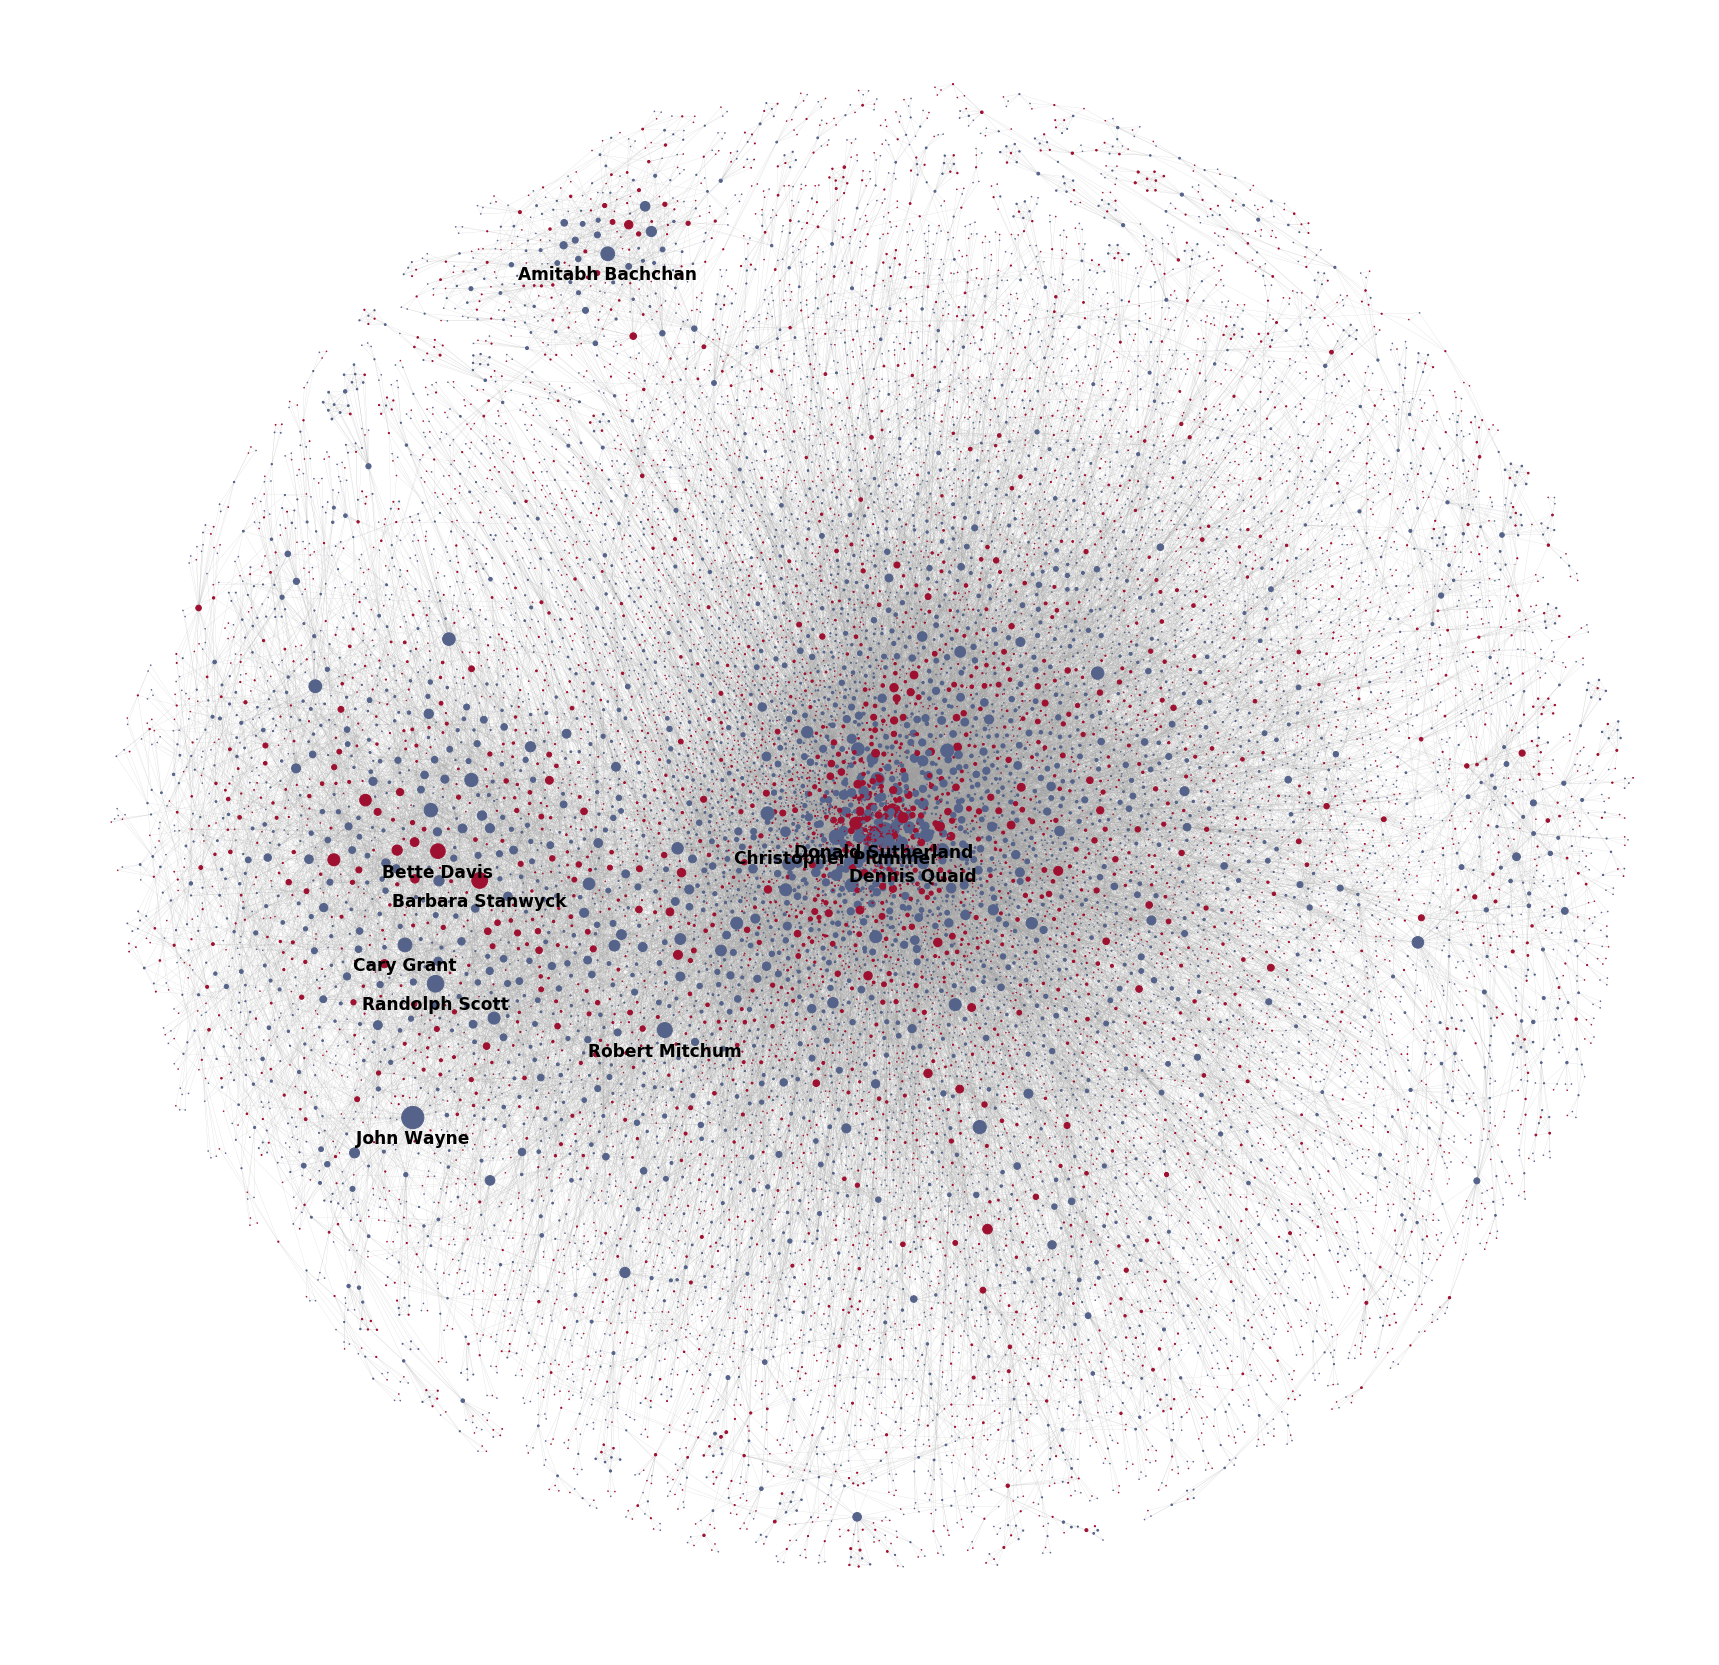

In [24]:
#-------
# DRAW
#-------

fig = plt.figure(figsize=(30, 30))
nx.draw_networkx(G, positions, 
                 node_size = [(0.2*sizes[n])**(2) for n in G.nodes()],  node_color = [colors[n] for n in G.nodes()],
                 with_labels=True,
                 width = 0.1,edge_color="#999999",labels = labels,font_size = 17, font_weight= "bold")
plt.axis('off')
plt.show()

## Basic statistics 

### Nodes & Edges

In [29]:
print "There are "+str(G.number_of_nodes()) +" nodes(actors) and "+ str(G.number_of_edges())+ " links(movie collaboration)."

There are 16759 nodes(actors) and 55101 links(movie collaboration).


### Degree Distributions

In [44]:
#---------------------
# HISTOGRAM FUNCTION
#---------------------

def histogram(degrees, dens):
    # Computing Bins
    min_bin = np.amin(degrees)
    max_bin = np.amax(degrees)
    nb_bins = int(math.ceil(max_bin)-math.floor(min_bin))
    v = np.empty(nb_bins+1)
    v[nb_bins] = int(math.ceil(max_bin))
    bins = np.empty(nb_bins)
    for i in range(nb_bins):
        v[i] = int(min_bin + i)
        bins[i] = int(min_bin + i)

    #Hist
    hist, bin_edges = np.histogram(degrees,bins = v,density=dens)
    return hist, bin_edges

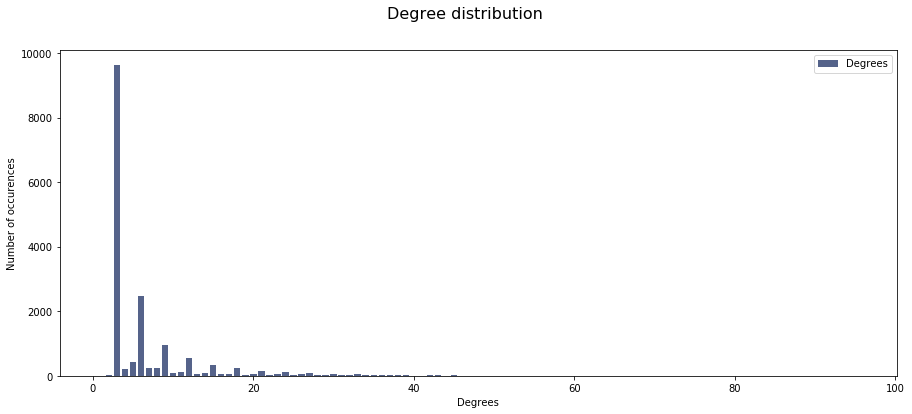

In [45]:
#-------------------------------
# DISPLAY THE DEGREE HISTOGRAM 
#-------------------------------

# Get the degrees
degrees = [G.degree(n) for n in G.nodes()]

# Get the histograms
hist, bins = histogram(degrees,False)
histD, binsD = histogram(degrees,True)

# Plot
plt.figure(figsize = (15,6))
plt.bar(bins[:-1], hist, 0.8, color=mBlue, label = "Degrees")
plt.xlabel('Degrees')
plt.ylabel('Number of occurences')
plt.suptitle('Degree distribution', fontsize=16)
plt.legend()
plt.show()

In [38]:
#Defining functions to plot against a random network and a scale free network
def PoissDegree(ks,avg):
    return [np.exp(-avg)*avg**k/math.factorial(int(k)) for k in ks]
def ScaleFreeDegree(ks,gamma):
    return [k**(-gamma)/zeta(gamma) for k in ks]

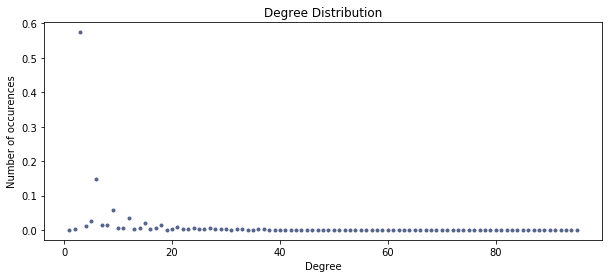

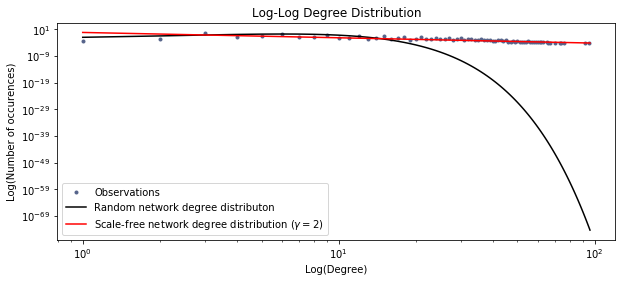

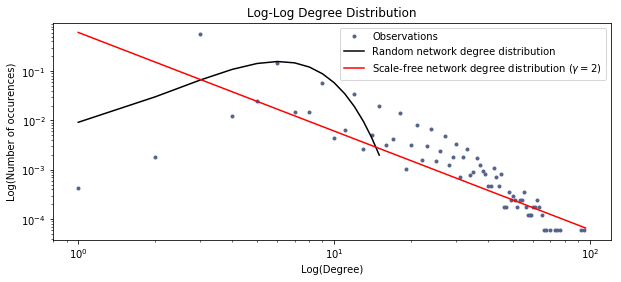

In [52]:
# Normal plot        
plt.figure(figsize = (10,4))
plt.title("Degree Distribution")
plt.plot(binsD[:-1], histD, '.', color=mBlue)
plt.xlabel('Degree')
plt.ylabel('Number of occurences')
plt.show()

# Log-Log Plot
plt.figure(figsize = (10,4))
plt.title("Log-Log Degree Distribution")
plt.loglog(binsD[:-1], histD, '.', color=mBlue)
plt.xlabel('Log(Degree)')
plt.ylabel('Log(Number of occurences)')
avg = np.mean(degrees)
ks = np.linspace(1,np.max(degrees),np.max(degrees))
plt.loglog(ks,PoissDegree(ks,avg),"-",color="k")
plt.loglog(ks,ScaleFreeDegree(ks,2),"-",color="r")
plt.legend(["Observations","Random network degree distributon","Scale-free network degree distribution ($\gamma = 2$)"])
plt.show()

# Log-Log Plot zoom on scale free
plt.figure(figsize = (10,4))
plt.title("Log-Log Degree Distribution")
plt.loglog(binsD[:-1], histD, '.', color=mBlue)
plt.xlabel('Log(Degree)')
plt.ylabel('Log(Number of occurences)')
avg = np.mean(degrees)
ks = np.linspace(1,np.max(degrees),np.max(degrees))
ks2 = np.linspace(1,15,15)
plt.loglog(ks2,PoissDegree(ks2,avg),"-",color="k")
plt.loglog(ks,ScaleFreeDegree(ks,2),"-",color="r")
plt.legend(["Observations","Random network degree distribution","Scale-free network degree distribution ($\gamma = 2$)"])
plt.show()